# Setting Up All Artifacts details

In [1]:
import os
os.environ['QNN_SDK_ROOT']="/local/mnt/workspace/gokul/QNN/2.19.0.240124" #set up your qnn path here.
os.environ['ANDROID_NDK_ROOT']="/local/mnt/workspace/gokul/android-ndk-r25c"
os.environ['RAW_FILE_FOLDER']="raw"
os.environ['MODEL_NAME']="yolo_nas_fp32"
os.environ['QUANTIZED_MODEL_NAME']="yolo_nas_w8a8"
os.environ['MODEL_PATH']="models/yolo_nas_fp32"
os.environ['QUANTIZED_MODEL_PATH']="models/yolo_nas_w8a8"
os.environ['TARGET_INPUT_LIST']="input.txt"
os.environ['ONDEVICE_FOLDER']="yolonas"
os.environ['DEVICE_HOST']="localhost"
os.environ['DEVICE_ID']="bc468c1d" #fill your device-id. Use command "adb devices" to get devices names. example :"e18d5d0"
os.environ['QNN_TARGET_ARCH']="aarch64-android"
os.environ['QNN_TARGET_STL']="libQnnHtp.so"

In [2]:
## Note- Use python3.8 or above for generating onnx
!pip install super-gradients==3.1.2
import torch
from super_gradients.training import models
from super_gradients.common.object_names import Models
import cv2
import numpy as np
import os


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


[2024-03-04 08:54:49] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /local/mnt/workspace/gokul/sg_logs/console.log


2024-03-04 08:54:50.729449: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-04 08:54:50.757589: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 08:54:51.223463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[2024-03-04 08:54:51] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-03-04 08:54:51] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-03-04 08:54:51] WARNING - export.py - Failed to import pytorch_quantization
[2024-03-

## Getting The dataset

In [3]:
!wget https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels.zip -q --show-progress
!wget http://images.cocodataset.org/zips/val2017.zip -q --show-progress
!unzip val2017.zip
!unzip coco2017labels.zip
!mkdir "raw"

In [4]:
files = os.listdir('val2017')
for file in files[15:]:
    os.remove("val2017/"+file)

In [5]:
%%bash
rm -rf coco
rm -rf coco2017labels.zip
rm -rf val2017.zip

## Getting the ONNX Model

In [6]:
os.makedirs('models', exist_ok=True)

In [7]:
model = models.get(Models.YOLO_NAS_S, pretrained_weights="coco")
# Prpare model for conversion
# Input size is in format of [Batch x Channels x Width x Height] where 640 is the standard COCO dataset dimensions
model.eval()
model.prep_model_for_conversion(input_size=[1, 3, 320, 320])
# Create dummy_input
dummy_input = torch.randn([1, 3, 320, 320], device="cpu")
# Convert model to onnx
torch.onnx.export(model, dummy_input, "models/yolo_nas_s.onnx", opset_version=11)

[2024-03-04 08:54:52] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


## Preprocessing

In [8]:
def preprocess(original_image):
    resized_image = cv2.resize(original_image, (320, 320))
    resized_image = resized_image/255
    return resized_image
##Please download Coco2014 dataset and give the path here
dataset_path = "val2017/"
!mkdir -p rawYoloNAS
filenames=[]
for path in os.listdir(dataset_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dataset_path, path)):
        filenames.append(os.path.join(dataset_path, path))
for filename in filenames:
    original_image = cv2.imread(filename)
    img = preprocess(original_image)
    img = img.astype(np.float32)
    img.tofile("raw/"+filename.split("/")[-1].split(".")[0]+".raw")

In [9]:
%%bash
find raw -name *.raw > input.txt

## Quantize the DLC

In [10]:
%%bash
source ${QNN_SDK_ROOT}/bin/envsetup.sh
export PATH=${ANDROID_NDK_ROOT}:${PATH}
${QNN_SDK_ROOT}/bin/x86_64-linux-clang/qnn-onnx-converter --input_network models/yolo_nas_s.onnx --output_path ${MODEL_PATH}.cpp
${QNN_SDK_ROOT}/bin/x86_64-linux-clang/qnn-model-lib-generator -c ${MODEL_PATH}.cpp -b ${MODEL_PATH}.bin -o models/model_libs
${QNN_SDK_ROOT}/bin/x86_64-linux-clang/qnn-context-binary-generator \
              --backend ${QNN_SDK_ROOT}/lib/x86_64-linux-clang/libQnnHtp.so \
              --model models/model_libs/x86_64-linux-clang/lib${MODEL_NAME}.so \
              --binary_file ${MODEL_NAME}.serialized

In [11]:
%%bash
source ${QNN_SDK_ROOT}/bin/envsetup.sh
export PATH=${ANDROID_NDK_ROOT}:${PATH}
${QNN_SDK_ROOT}/bin/x86_64-linux-clang/qnn-onnx-converter --input_network models/yolo_nas_s.onnx --output_path ${QUANTIZED_MODEL_PATH}.cpp --input_list input.txt \
                --param_quantizer "adjusted" --act_quantizer "enhanced"
${QNN_SDK_ROOT}/bin/x86_64-linux-clang/qnn-model-lib-generator -c ${QUANTIZED_MODEL_PATH}.cpp -b ${QUANTIZED_MODEL_PATH}.bin -o models/model_libs2
${QNN_SDK_ROOT}/bin/x86_64-linux-clang/qnn-context-binary-generator \
              --backend ${QNN_SDK_ROOT}/lib/x86_64-linux-clang/libQnnHtp.so \
              --model models/model_libs2/x86_64-linux-clang/lib${QUANTIZED_MODEL_NAME}.so \
              --binary_file ${QUANTIZED_MODEL_NAME}.serialized

[INFO] AISW SDK environment set
[INFO] QNN_SDK_ROOT: /local/mnt/workspace/gokul/QNN/2.19.0.240124


2024-03-04 08:54:55,282 - 235 - INFO - Simplified model validation is successful
2024-03-04 08:54:57,410 - 235 - INFO - Saving QNN Model...


IrQuantizer: Quantizer param type: adjusted will be deprecated in future releases
IrQuantizer: Quantizer type: adjusted is no longer supported. Using TF quantizer instead


2024-03-04 08:55:04,161 - 235 - INFO - Model CPP saved at: models/yolo_nas_w8a8.cpp 
2024-03-04 08:55:04,162 - 235 - INFO - Model BIN saved at: /local/mnt/workspace/gokul/models-for-solutions/03-object-detection/yolonas/models/yolo_nas_w8a8.bin 
2024-03-04 08:55:04,165 - 235 - INFO - Conversion complete!


     0.1ms [  INFO ] Inferences will run in sync mode
     0.2ms [  INFO ] Initializing logging in the backend. Callback: [0x7ffa20ef2e10], Log Level: [3]
     0.2ms [  INFO ] No BackendExtensions lib provided;initializing NetRunBackend Interface
     0.2ms [WARNING] Unable to find a device with NetRunDeviceKeyDefault in Library NetRunBackendLibKeyDefault
     0.3ms [  INFO ] Entering QuantizeRuntimeApp flow
    15.5ms [  INFO ] CpuGraph::finalize
    41.8ms [  INFO ] CpuGraph::execute
   716.1ms [  INFO ] cleaning up resources for input tensors
   716.1ms [  INFO ] cleaning up resources for output tensors
   718.7ms [  INFO ] CpuGraph::execute
  1155.6ms [  INFO ] cleaning up resources for input tensors
  1155.6ms [  INFO ] cleaning up resources for output tensors
  1157.3ms [  INFO ] CpuGraph::execute
  1551.7ms [  INFO ] cleaning up resources for input tensors
  1551.7ms [  INFO ] cleaning up resources for output tensors
  1553.5ms [  INFO ] CpuGraph::execute
  1942.1ms [  INFO ] cl

jni/yolo_nas_w8a8.cpp:39:42: warning: mixture of designated and non-designated initializers in the same initializer list is a C99 extension [-Wc99-designator]
                                         .id=0,
                                         ^~~~~
jni/QnnWrapperUtils.hpp:77:17: note: expanded from macro 'VALIDATE'
    retStatus = value;                                                                           \
                ^~~~~
jni/yolo_nas_w8a8.cpp:50:42: note: first non-designated initializer is here
                                         {.clientBuf= { .data=nullptr,
                                         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
jni/QnnWrapperUtils.hpp:77:17: note: expanded from macro 'VALIDATE'
    retStatus = value;                                                                           \
                ^~~~~
jni/yolo_nas_w8a8.cpp:37:40: warning: mixture of designated and non-designated initializers in the same initializer list is a C99 extension [-Wc99-des

/local/mnt/workspace/gokul/android-ndk-r25c/toolchains/llvm/prebuilt/linux-x86_64/bin/llvm-objcopy -I binary -O elf64-littleaarch64 -B aarch64 obj/binary/backbone_stage1_blocks_bottlenecks_0_alpha.raw obj/local/arm64-v8a/objs/yolo_nas_w8a8//backbone_stage1_blocks_bottlenecks_0_alpha.o
/local/mnt/workspace/gokul/android-ndk-r25c/toolchains/llvm/prebuilt/linux-x86_64/bin/llvm-objcopy -I binary -O elf64-littleaarch64 -B aarch64 obj/binary/backbone_stage1_blocks_bottlenecks_0_cv1_rbr_reparam_bias.raw obj/local/arm64-v8a/objs/yolo_nas_w8a8//backbone_stage1_blocks_bottlenecks_0_cv1_rbr_reparam_bias.o
/local/mnt/workspace/gokul/android-ndk-r25c/toolchains/llvm/prebuilt/linux-x86_64/bin/llvm-objcopy -I binary -O elf64-littleaarch64 -B aarch64 obj/binary/backbone_stage1_blocks_bottlenecks_0_cv1_rbr_reparam_weight.raw obj/local/arm64-v8a/objs/yolo_nas_w8a8//backbone_stage1_blocks_bottlenecks_0_cv1_rbr_reparam_weight.o
/local/mnt/workspace/gokul/android-ndk-r25c/toolchains/llvm/prebuilt/linux-x86

In [12]:
%%bash
adb devices

In [13]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell "mkdir -p /data/local/tmp/qnnexample/$QNN_TARGET_ARCH/bin" && $DEVICE_SHELL shell "mkdir -p /data/local/tmp/qnnexample/$QNN_TARGET_ARCH/lib" && $DEVICE_SHELL shell "mkdir -p /data/local/tmp/qnnexample/dsp/lib"

In [14]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell "mkdir -p /data/local/tmp/$ONDEVICE_FOLDER"

List of devices attached
bc468c1d	device



In [15]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL push $QNN_SDK_ROOT/lib/$QNN_TARGET_ARCH/$QNN_TARGET_STL /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $QNN_SDK_ROOT/bin/$QNN_TARGET_ARCH/qnn-net-run /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $QNN_SDK_ROOT/lib/hexagon-v73/unsigned/*.so /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $QNN_SDK_ROOT/lib/$QNN_TARGET_ARCH/*.so /data/local/tmp/$ONDEVICE_FOLDER

/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/aarch64-android/libQnnHtp.so: 1 file pushed, 0 skipped. 409.7 MB/s (1545520 bytes in 0.004s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/bin/aarch64-android/qnn-net-run: 1 file pushed, 0 skipped. 423.2 MB/s (1441208 bytes in 0.003s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/hexagon-v73/unsigned/libCalculator_skel.so: 1 file pushed, 0 skipped. 131.5 MB/s (7128 bytes in 0.000s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/hexagon-v73/unsigned/libQnnHtpV73QemuDriver.so: 1 file pushed, 0 skipped. 503.3 MB/s (7601584 bytes in 0.014s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/hexagon-v73/unsigned/libQnnHtpV73Skel.so: 1 file pushed, 0 skipped. 512.7 MB/s (7360784 bytes in 0.014s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/hexagon-v73/unsigned/libQnnHtpV73.so: 1 file pushed, 0 skipped. 514.8 MB/s (8025008 bytes in 0.015s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/hexagon-v73/unsigned/libQnnSaver.so: 1 file pushed,

In [16]:
%%bash
#find ./raw -name *.raw > list.txt
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL push output/${QUANTIZED_MODEL_NAME}.serialized.bin /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push output/${MODEL_NAME}.serialized.bin /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push models/model_libs2/aarch64-android/lib${QUANTIZED_MODEL_NAME}.so /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $RAW_FILE_FOLDER /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $TARGET_INPUT_LIST /data/local/tmp/$ONDEVICE_FOLDER

/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/aarch64-android/libhta_hexagon_runtime_qnn.so: 1 file pushed, 0 skipped. 440.7 MB/s (2789832 bytes in 0.006s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/aarch64-android/libQnnChrometraceProfilingReader.so: 1 file pushed, 0 skipped. 428.2 MB/s (516568 bytes in 0.001s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/aarch64-android/libQnnCpu.so: 1 file pushed, 0 skipped. 525.5 MB/s (4822376 bytes in 0.009s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/aarch64-android/libQnnDspNetRunExtensions.so: 1 file pushed, 0 skipped. 471.7 MB/s (634024 bytes in 0.001s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/aarch64-android/libQnnDsp.so: 1 file pushed, 0 skipped. 447.3 MB/s (1238520 bytes in 0.003s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/aarch64-android/libQnnDspV66CalculatorStub.so: 1 file pushed, 0 skipped. 374.1 MB/s (6368 bytes in 0.000s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/aarch64-android/libQnnDspV66Stu

In [17]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell
export ONDEVICE_FOLDER="yolonas"
export device_path=/data/local/tmp/$ONDEVICE_FOLDER
export LD_LIBRARY_PATH=$device_path
export ADSP_LIBRARY_PATH="$device_path"
export PATH=$PATH:$device_path
export QUANTIZED_MODEL_NAME="yolo_nas_w8a8"
cd $device_path
export OUTPUT_FOLDER=OUTPUT_Quant_DSP
cd /data/local/tmp/$ONDEVICE_FOLDER  && 
./qnn-net-run --backend libQnnHtp.so --input_list input.txt --retrieve_context ${QUANTIZED_MODEL_NAME}.serialized.bin --output_dir $OUTPUT_FOLDER

models/model_libs2/aarch64-android/libyolo_nas_w8a8.so: 1 file pushed, 0 skipped. 478.7 MB/s (12991032 bytes in 0.026s)
raw/: 14 files pushed, 0 skipped. 172.4 MB/s (17203200 bytes in 0.095s)
input.txt: 1 file pushed, 0 skipped. 7.1 MB/s (294 bytes in 0.000s)
qnn-net-run pid:12205


In [18]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell
export ONDEVICE_FOLDER="yolonas"
export device_path=/data/local/tmp/$ONDEVICE_FOLDER
export LD_LIBRARY_PATH=$device_path
export ADSP_LIBRARY_PATH="$device_path"
export PATH=$PATH:$device_path
export QUANTIZED_MODEL_NAME="yolo_nas_w8a8"
cd $device_path
export OUTPUT_FOLDER=OUTPUT_CPU
cd /data/local/tmp/$ONDEVICE_FOLDER  && 
./qnn-net-run --backend libQnnCpu.so --input_list input.txt --model lib${QUANTIZED_MODEL_NAME}.so --output_dir $OUTPUT_FOLDER

qnn-net-run pid:12213


In [19]:
os.makedirs('output',exist_ok=True)

## Pull output from device

In [20]:
%%bash
rm -rf OUTPUT_Quant_DSP
rm -rf OUTPUT_CPU

In [21]:
%%bash

export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL pull /data/local/tmp/$ONDEVICE_FOLDER/OUTPUT_Quant_DSP output/OUTPUT_Quant_DSP
$DEVICE_SHELL pull /data/local/tmp/$ONDEVICE_FOLDER/OUTPUT_CPU output/OUTPUT_CPU

In [22]:
def ImageNames():
    inputlist = open('input.txt', 'r')
    Lines = inputlist.readlines()
    count = 0
    imageList = []
    for line in Lines:
        name = line.split("/",1)[1]
        name = name.split('.')[0]
        imageList.append(name)
        count += 1
    return imageList
imageList = ImageNames()
print((imageList))

In [23]:
label2class = {'0': 'person', '1': 'bicycle', '2': 'car', '3': 'motorcycle', '4': 'airplane', '5': 'bus', 
               '6': 'train', '7': 'truck', '8': 'boat', '9': 'traffic', '10': 'fire', '11': 'stop', '12': 'parking', 
               '13': 'bench', '14': 'bird', '15': 'cat', '16': 'dog', '17': 'horse', '18': 'sheep', '19': 'cow', 
               '20': 'elephant', '21': 'bear', '22': 'zebra', '23': 'giraffe', '24': 'backpack', '25': 'umbrella', 
               '26': 'handbag', '27': 'tie', '28': 'suitcase', '29': 'frisbee', '30': 'skis', '31': 'snowboard', 
               '32': 'sports', '33': 'kite', '34': 'baseball', '35': 'baseball', '36': 'skateboard', '37': 'surfboard', 
               '38': 'tennis', '39': 'bottle', '40': 'wine', '41': 'cup', '42': 'fork', '43': 'knife', '44': 'spoon', 
               '45': 'bowl', '46': 'banana', '47': 'apple', '48': 'sandwich', '49': 'orange', '50': 'broccoli', 
               '51': 'carrot', '52': 'hot', '53': 'pizza', '54': 'donut', '55': 'cake', '56': 'chair', '57': 'couch', 
               '58': 'potted', '59': 'bed', '60': 'dining', '61': 'toilet', '62': 'tv', '63': 'laptop', '64': 'mouse', 
               '65': 'remote', '66': 'keyboard', '67': 'cell', '68': 'microwave', '69': 'oven', '70': 'toaster', 
               '71': 'sink', '72': 'refrigerator', '73': 'book', '74': 'clock', '75': 'vase', '76': 'scissors', 
               '77': 'teddy', '78': 'hair', '79': 'toothbrush'}

/data/local/tmp/yolonas/OUTPUT_Quant_DSP/: 28 files pulled, 0 skipped. 37.9 MB/s (9878400 bytes in 0.249s)
/data/local/tmp/yolonas/OUTPUT_CPU/: 28 files pulled, 0 skipped. 53.8 MB/s (9878400 bytes in 0.175s)
['000000534664', '000000537153', '000000481404', '000000229358', '000000558854', '000000559513', '000000513688', '000000566758', '000000545129', '000000546976', '000000463918', '000000578922', '000000567432', '000000554002']


## Post Processing 

In [24]:
from matplotlib import pyplot as plt
import cv2.dnn
import numpy as np
colors = np.random.uniform(0, 255, size=(len(list(label2class.values())), 3))
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = f'{label2class[str(class_id)]} ({confidence:.2f})'
    color = colors[class_id]
    img = cv2.rectangle(img, (x, y), (x_plus_w, y_plus_h), color, 1)
    img = cv2.putText(img, label, (x +2, y -10), cv2.FONT_HERSHEY_TRIPLEX, 1, color, 4)
    return img

In [25]:
def postProc(filename, output1, output2, out_path):

    output1_reshape = output1.reshape(2100,4)
    output2_reshape = output2.reshape(2100,80)
    output = output2_reshape
    
    original_image: np.ndarray = cv2.imread(filename)
    ratio_1 = original_image.shape[0]/320
    ratio_2 = original_image.shape[1]/320
    
    boxes = []
    scores = []
    class_ids = []
        
    for i in range(0, output.shape[0]):
        classes_scores = output[i]
        (minScore, maxScore, minClassLoc, (x, maxClassIndex)) = cv2.minMaxLoc(classes_scores)
        if maxScore >= 0.05:
            x = round(output1_reshape[i][0]) ; y = round(output1_reshape[i][1]); 
            w = round(output1_reshape[i][2]) ; h = round(output1_reshape[i][3]);
            
            x1, y1 = x, y
            x2, y2 = w, h
            box = [x1, y1, x2, y2]
            boxes.append(box)
            scores.append(float(maxScore))
            class_ids.append(maxClassIndex)
            if(len(boxes)==704) or len(boxes)== 693:
                print("i = ",i)
                print("x = ",x)#x1
                print("y = ",y)#y1
                print("w = ",w)#x2
                print("h = ",h)#y2
                print(box)
    result_boxes = cv2.dnn.NMSBoxes(boxes, scores, 0.20, 0.5, 0.5) #32b CPU
    
    print("result_boxes :: ",result_boxes)
    detections = []
    img = original_image
    for i in range(len(result_boxes)):
        index = result_boxes[i]
        box = boxes[index]
        detection = {
            'class_id': class_ids[index],
            'class_name': label2class[str(class_ids[index])],
            'confidence': scores[index],
            'box': box
             }
        detections.append(detection)
        img = draw_bounding_box(original_image, class_ids[index], scores[index], int(box[0]*ratio_2), int(box[1]*ratio_1), int(box[2]*ratio_2), int(box[3]*ratio_1))
        print(detection)
        print("boxcords::",int(box[0]), int(box[1]), int(box[2]), int(box[3]))
        print("boxcords::",int(box[0]*ratio_2), int(box[1]*ratio_1), int(box[2]*ratio_2), int(box[3]*ratio_1))
    #     cv2.imwrite("test.jpg", img)
        plt.imsave(out_path,img)
        # plt.show()
        

In [26]:
os.makedirs('output/32b_arm', exist_ok=True)
os.makedirs('output/8b_dsp', exist_ok=True)

## Save results on CPU

In [27]:
test_images_dir = "output/OUTPUT_CPU"
image_dir = 'val2017/'
import cv2
import os
import numpy as np
import torch
from PIL import Image
for i in range(0,len(imageList)):
    img_path = image_dir+imageList[i]+'.jpg'
    raw_path = os.path.join(test_images_dir, 'Result_')
    output1 = np.fromfile(raw_path+str(i)+'/_885.raw',dtype="float32")
    output2 = np.fromfile(raw_path+str(i)+'/_877.raw',dtype="float32")
    print(output1.shape)
    print(output2.shape)
    out_path = 'output/32b_arm/'+imageList[i]+'_prediction_32b_arm.png'
    postProc(img_path,output1,output2,out_path)
    i = i +1

(8400,)
(168000,)
result_boxes ::  [388 257 316 426 181 187 267 431]
{'class_id': 28, 'class_name': 'suitcase', 'confidence': 0.805215060710907, 'box': [0, 0, 209, 324]}
boxcords:: 0 0 209 324
boxcords:: 0 0 418 409
{'class_id': 28, 'class_name': 'suitcase', 'confidence': 0.7254531979560852, 'box': [211, 91, 317, 208]}
boxcords:: 211 91 317 208
boxcords:: 422 114 634 262
{'class_id': 28, 'class_name': 'suitcase', 'confidence': 0.7102604508399963, 'box': [208, 194, 321, 317]}
boxcords:: 208 194 321 317
boxcords:: 416 244 642 400
{'class_id': 28, 'class_name': 'suitcase', 'confidence': 0.6988658905029297, 'box': [0, 143, 82, 314]}
boxcords:: 0 143 82 314
boxcords:: 0 180 164 396
{'class_id': 28, 'class_name': 'suitcase', 'confidence': 0.5963149070739746, 'box': [204, 0, 321, 110]}
boxcords:: 204 0 321 110
boxcords:: 408 0 642 138
{'class_id': 28, 'class_name': 'suitcase', 'confidence': 0.48236939311027527, 'box': [0, 0, 89, 169]}
boxcords:: 0 0 89 169
boxcords:: 0 0 178 213
{'class_id': 

## Save results on DSP

In [28]:
test_images_dir = "output/OUTPUT_Quant_DSP"
image_dir = 'val2017/'
import cv2
import os
import numpy as np
import torch
from PIL import Image
for i in range(0,len(imageList)):
    img_path = image_dir+imageList[i]+'.jpg'
    raw_path = os.path.join(test_images_dir, 'Result_')
    output1 = np.fromfile(raw_path+str(i)+'/_885.raw',dtype="float32")
    output2 = np.fromfile(raw_path+str(i)+'/_877.raw',dtype="float32")
    print(output1.shape)
    print(output2.shape)
    out_path = 'output/8b_dsp/'+imageList[i]+'_prediction_8b_dsp.png'
    postProc(img_path,output1,output2,out_path)
    i = i +1

{'class_id': 26, 'class_name': 'handbag', 'confidence': 0.23928560316562653, 'box': [40, 0, 63, 37]}
boxcords:: 40 0 63 37
boxcords:: 80 0 126 49
{'class_id': 0, 'class_name': 'person', 'confidence': 0.23928560316562653, 'box': [51, 0, 72, 85]}
boxcords:: 51 0 72 85
boxcords:: 102 0 144 112
(8400,)
(168000,)
result_boxes ::  [380 418 250 309 188 182 261 398 422]
{'class_id': 28, 'class_name': 'suitcase', 'confidence': 0.7938205003738403, 'box': [0, 0, 215, 324]}
boxcords:: 0 0 215 324
boxcords:: 0 0 430 409
{'class_id': 28, 'class_name': 'suitcase', 'confidence': 0.7254531979560852, 'box': [0, 148, 89, 319]}
boxcords:: 0 148 89 319
boxcords:: 0 186 178 402
{'class_id': 28, 'class_name': 'suitcase', 'confidence': 0.7102604508399963, 'box': [208, 91, 316, 208]}
boxcords:: 208 91 316 208
boxcords:: 416 114 632 262
{'class_id': 28, 'class_name': 'suitcase', 'confidence': 0.6988658905029297, 'box': [204, 194, 321, 317]}
boxcords:: 204 194 321 317
boxcords:: 408 244 642 400
{'class_id': 28, 

## Output on CPU

{'class_id': 26, 'class_name': 'handbag', 'confidence': 0.21649649739265442, 'box': [40, 0, 63, 37]}
boxcords:: 40 0 63 37
boxcords:: 80 0 126 49


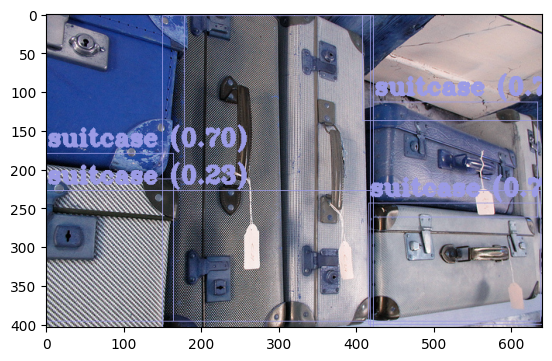

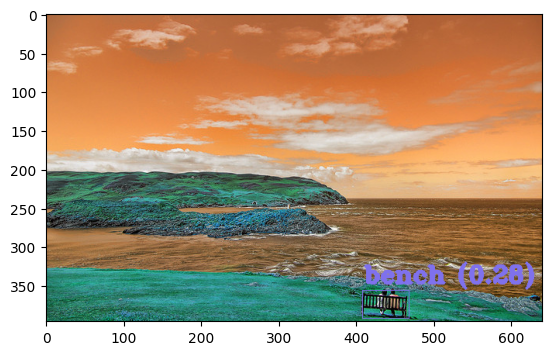

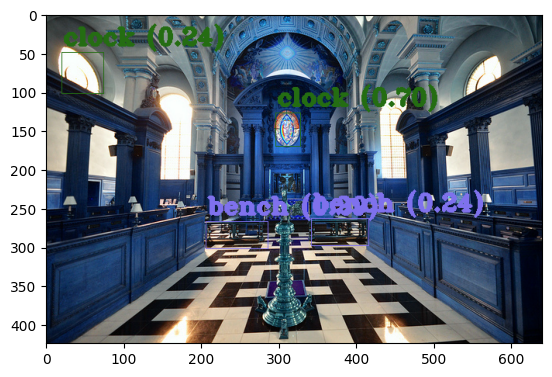

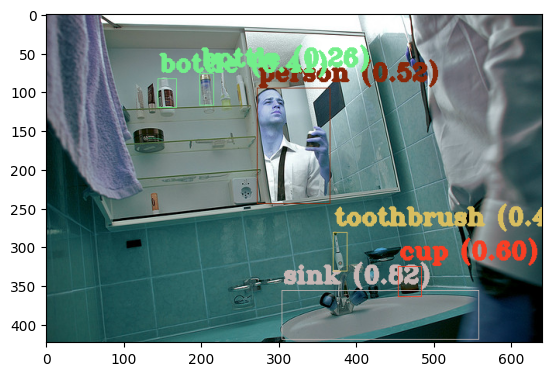

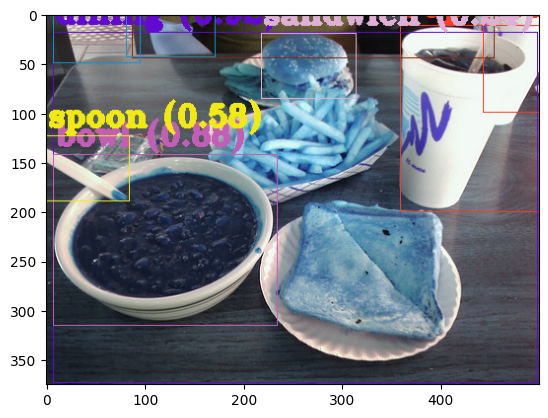

In [29]:
for i in range(5):
    img  = plt.imread('output/32b_arm/'+imageList[i]+'_prediction_32b_arm.png')
    plt.imshow(img)
    plt.show()

## Output on DSP

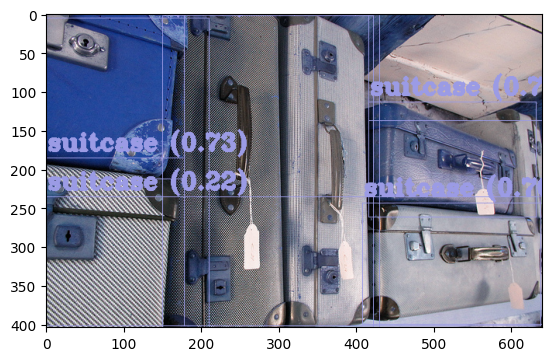

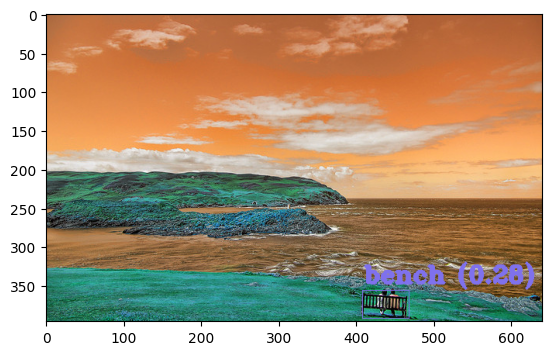

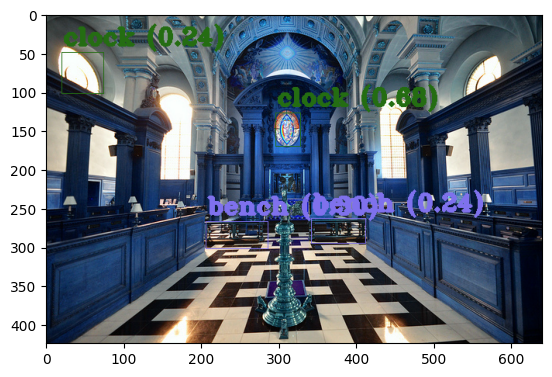

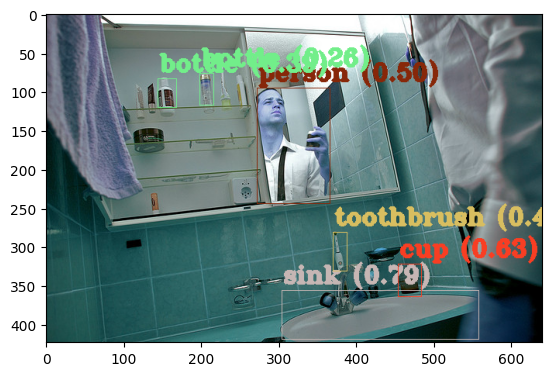

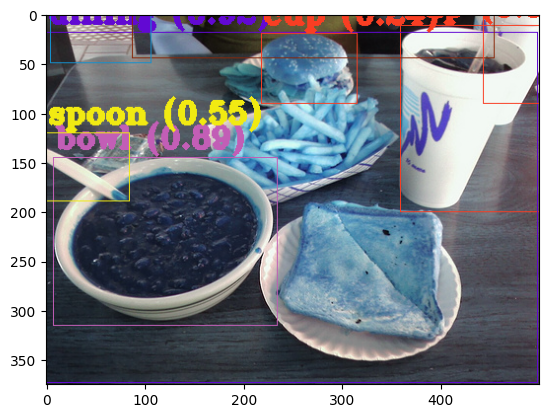

In [30]:
for i in range(5):
    img  = plt.imread('output/8b_dsp/'+imageList[i]+'_prediction_8b_dsp.png')
    plt.imshow(img)
    plt.show()